<a href="https://colab.research.google.com/github/erd3muysal/gender_classification/blob/main/gender_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and Extract Data

In [1]:
# Download data
!curl -O http://www.openslr.org/resources/12/dev-clean.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  322M  100  322M    0     0  10.3M      0  0:00:31  0:00:31 --:--:-- 11.2M


In [2]:
# Extract data
!tar -xvzf dev-clean.tar.gz

LibriSpeech/LICENSE.TXT
LibriSpeech/README.TXT
LibriSpeech/CHAPTERS.TXT
LibriSpeech/SPEAKERS.TXT
LibriSpeech/BOOKS.TXT
LibriSpeech/dev-clean/
LibriSpeech/dev-clean/2277/
LibriSpeech/dev-clean/2277/149896/
LibriSpeech/dev-clean/2277/149896/2277-149896-0026.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0005.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0033.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0006.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0018.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0034.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0021.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0015.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0012.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0027.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0007.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0030.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0011.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0009.flac
LibriSpeech

# Exploratory Data Analysis

## Import Necessary Packages

In [3]:
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data operations
import matplotlib.pyplot as plt  # Library for visualization
import seaborn as sns  # Library for visualization
import os
import librosa  # Library for processing audio data
import librosa.display
import IPython.display as ipd  # Library for playing sound in the notebook
from tqdm import tqdm_notebook  # Library for process bar

np.random.seed(42)
%matplotlib inline
plt.style.use('ggplot')

In [4]:
ROOT = '/content'  # Root directory
BASE = '/LibriSpeech/dev-clean'  # Dataset directory

## Understanding Data

Before creating Deep Learning model, lets dive into dataset and see what kind of data included in our dataset in order to get better understanding of task.

In [5]:
# List speaker ids into a variable
speaker_idx = os.listdir(ROOT + BASE)
# Find and then sort all unique speakers in the list
speaker_idx = sorted(speaker_idx)
print(speaker_idx)
print()
print("There are", len(speaker_idx), "unique speakers in the dataset.")

['1272', '1462', '1673', '174', '1919', '1988', '1993', '2035', '2078', '2086', '2277', '2412', '2428', '251', '2803', '2902', '3000', '3081', '3170', '3536', '3576', '3752', '3853', '422', '5338', '5536', '5694', '5895', '6241', '6295', '6313', '6319', '6345', '652', '777', '7850', '7976', '8297', '84', '8842']

There are 40 unique speakers in the dataset.


SPEAKERS.TXT file contains all of the meta data about the speakers. However it also has some unnecessary lines that contains some explonations about the data. With these unnecessary lines, we are not able to create an apropriate dataframe for our project. For creating an apropriate dataframe, we should remove those lines.

In [6]:
# Remove first 12 lines of the 'SPEAKERS.TXT' file and saved it to new 'SPEAKERS_METADATA.TXT' file
!sed '1,12d' /content/LibriSpeech/SPEAKERS.TXT > /content/LibriSpeech/SPEAKERS_METADATA.TXT

In [7]:
# Create a meta dataframe from 'SPEAKERS_METADATA.TXT' file
meta_df = pd.read_csv('/content/LibriSpeech/SPEAKERS_METADATA.TXT', sep='|', index_col=False,  # Seperate 'SPEAKERS_METADATA.TXT' file w.r.t. '|'
                 names=['id', 'sex', 'subset', 'minutes', 'name'])  # Columns: 'id', 'sex', 'subset', 'minutes', 'name'

# Print first 5 lines of the dataframe
meta_df.head()

,id,sex,subset,minutes,name
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine


In [8]:
fnames = []  # File names storage
paths = []  # File paths storage

for speaker in os.listdir(ROOT + BASE):  # Traverse in speaker folders
  for book in os.listdir(ROOT + BASE + '/' + speaker):  # Traverse in book folders
    for record in os.listdir(ROOT + BASE + '/' + speaker + '/' + book):  # Traverse in record files
      if not record.endswith(".txt"):  # If file extension is not '.txt'
        fnames.append(record)  # Append each record into 'fnames'
        paths.append(ROOT + BASE + '/' + speaker + '/' + book + '/' + record)  # Append each record's path into 'paths'

# Sort 'fnames' and 'paths' for put them in same order in order to match file name with its path
fnames = sorted(fnames)  # Sort 'fnames'
paths = sorted(paths)  # Sort 'paths'

In [9]:
def get_id(fname):
  """
  A function to get speaker id from file name.

  Arguments:
  fname -- File name string

  Return:
  fname.split('-')[0] -- First element after seperation
  """
  return fname.split('-')[0]

In [10]:
def get_label(df, index):
  """
  A function to get label from speaker id.

  Arguments:
  df -- Dataframe that stores label information
  index -- Index of the file name whose label will be extracted

  Return:
  sub_df.iloc[0] -- Label that corresponds to indicated speaker id
  """
  sub_df = df.loc[df['id'] == int(get_id(fnames[index]))]['sex']
  return sub_df.iloc[0]

Let's see some examples to see if functions that we created above work properly.

In [11]:
print("File name: ", fnames[0])
print()
print("Path of the file: ", paths[0])
print()
print("Id of the speaker: ", get_id(fnames[0]))
print()
print("Label of the record: ", get_label(meta_df, 0))

File name:  1272-128104-0000.flac

Path of the file:  /content/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac

Id of the speaker:  1272

Label of the record:   M 


In [12]:
print("File name: ", fnames[2000])
print()
print("Path of the file: ", paths[2000])
print()
print("Id of the speaker: ", get_id(fnames[2000]))
print()
print("Label of the record: ", get_label(meta_df, 2000))

File name:  6313-66125-0023.flac

Path of the file:  /content/LibriSpeech/dev-clean/6313/66125/6313-66125-0023.flac

Id of the speaker:  6313

Label of the record:   F 


It is obvious that file names, their paths, their corresponding ids and labels are matching with each other.

## Examples from Dataset

Let's first listen some examples from our dataset and then visualize their spectrograms and wave plots. 

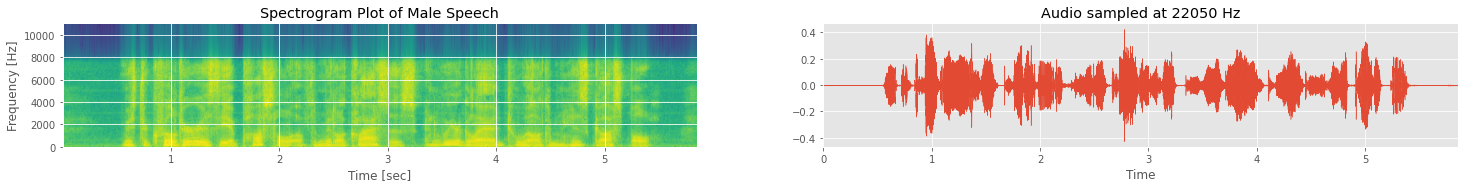

In [13]:
# Load speech recording
data, sampling_rate = librosa.load(paths[0])

plt.figure(figsize=(25, 5))  # Create a figure and set figure size

# Plot spectrogram
plt.subplot(221)  # Create subplot
plt.title("Spectrogram Plot of {}".format('Female Speech' if get_label(meta_df, 0) == 'F' else 'Male Speech'))  # Add title
plt.xlabel("Time [sec]")  # Add x-axis
plt.ylabel("Frequency [Hz]")  # Add y-axis
Pxx, freqs, bins, im = plt.specgram(data, Fs=sampling_rate)  # Show plot

# Plot wave diagram
plt.subplot(222)  # Create subplot
plt.title("Audio sampled at {} Hz".format(sampling_rate))  # Add title
librosa.display.waveplot(data, sr=sampling_rate)  # Show plot

# Play recording
ipd.Audio(paths[0])

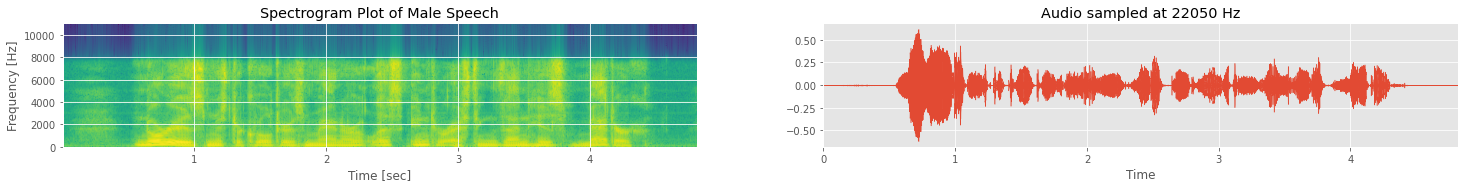

In [14]:
# Load speech recording
data, sampling_rate = librosa.load(paths[1])

plt.figure(figsize=(25, 5))  # Create a figure and set figure size

# Plot spectrogram
plt.subplot(221)  # Create subplot
plt.title("Spectrogram Plot of {}".format('Female Speech' if get_label(meta_df, 1) == 'F' else 'Male Speech'))  # Add title
plt.xlabel("Time [sec]")  # Add x-axis
plt.ylabel("Frequency [Hz]")  # Add y-axis
Pxx, freqs, bins, im = plt.specgram(data, Fs=sampling_rate)  # Show plot

# Plot wave diagram
plt.subplot(222)  # Create subplot
plt.title("Audio sampled at {} Hz".format(sampling_rate))  # Add title
librosa.display.waveplot(data, sr=sampling_rate)  # Show plot

# Play recording
ipd.Audio(paths[1])

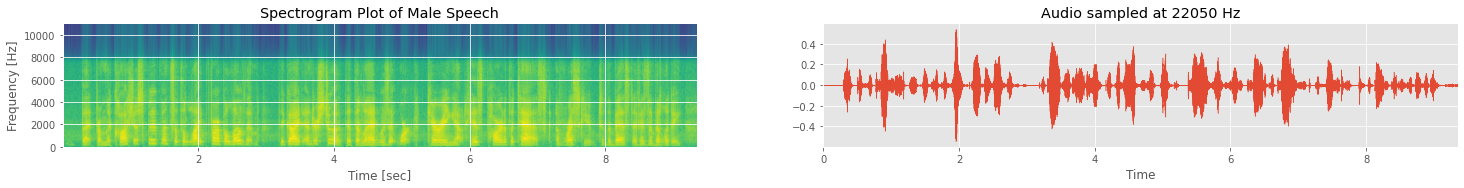

In [15]:
# Load speech recording
data, sampling_rate = librosa.load(paths[2000])

plt.figure(figsize=(25, 5))  # Create a figure and set figure size

# Plot spectrogram
plt.subplot(221)  # Create subplot
plt.title("Spectrogram Plot of {}".format('Female Speech' if get_label(meta_df, 2000) == 'F' else 'Male Speech'))  # Add title
plt.xlabel("Time [sec]")  # Add x-axis
plt.ylabel("Frequency [Hz]")  # Add y-axis
Pxx, freqs, bins, im = plt.specgram(data, Fs=sampling_rate)  # Show plot

# Plot wave diagram
plt.subplot(222)  # Create subplot
plt.title("Audio sampled at {} Hz".format(sampling_rate))  # Add title
librosa.display.waveplot(data, sr=sampling_rate)  # Show plot

# Play recording
ipd.Audio(paths[2000])

## Generating MFCC

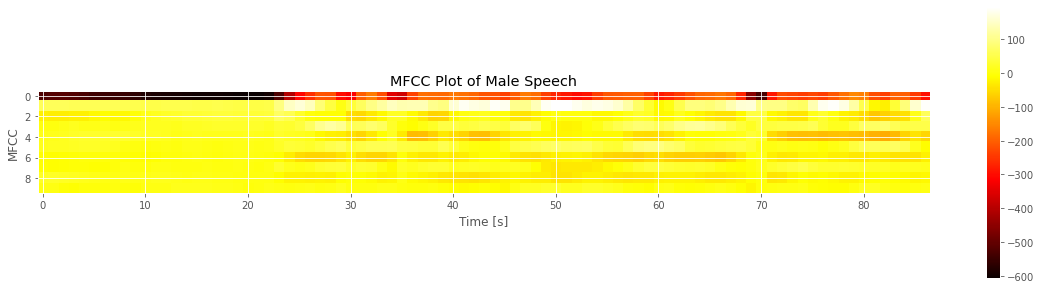

In [16]:
data, sampling_rate = librosa.load(paths[0])
data = data[:2 * sampling_rate]
mfcc = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=10)

# Plot MFCC
plt.figure(figsize=(20, 5))
plt.imshow(mfcc, cmap='hot', interpolation='nearest')
plt.title("MFCC Plot of {}".format('Female Speech' if get_label(meta_df, 0) == 'F' else 'Male Speech'))  # Add title
plt.xlabel("Time [s]")
plt.ylabel("MFCC")
plt.colorbar();

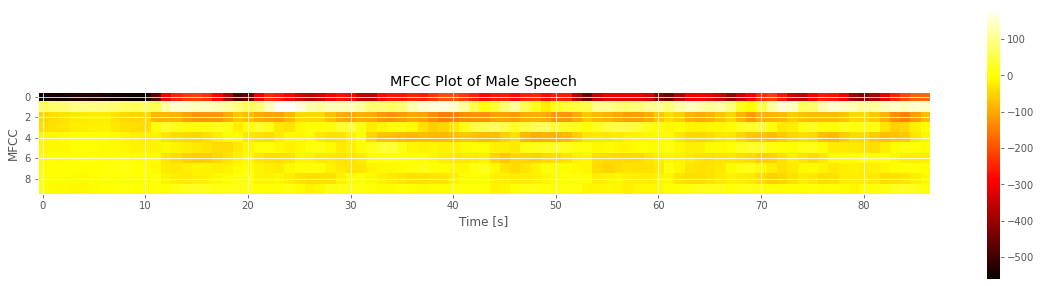

In [17]:
data, sampling_rate = librosa.load(paths[2000])
data = data[:2 * sampling_rate]
mfcc = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=10)

# MFCC
plt.figure(figsize=(20, 5))
plt.imshow(mfcc, cmap='hot', interpolation='nearest')
plt.title("MFCC Plot of {}".format('Female Speech' if get_label(meta_df, 2000) == 'F' else 'Male Speech'))  # Add title
plt.xlabel("Time [s]")
plt.ylabel("MFCC")
plt.colorbar();

Since MFCC data gives more information about speeches structure, we want to feed our model with MFCC data instead of raw speech data. For this purpose, we are traversing in our dataset and extracting MFCC features of each speech recordings then insert them into new dataframe. 

In [18]:
# Create a 'feature_df' dataframe for inserting MFCC data
features_df = pd.DataFrame(columns=['feature'])
# Create a 'labels_df' dataframe for inserting target values
labels_df = pd.DataFrame(columns=['target'])

# Loop over the entire dataset for feature extraction
counter = 0
for index, path in enumerate(paths):
    data, sampling_rate = librosa.load(path)
    # Take mean as the feature for scaled data 
    mfcc_scaled = np.mean(librosa.feature.mfcc(data, 
                                        sr=sampling_rate, 
                                        n_mfcc=10), 
                    axis=0)
    
    # Assign MFCC features into 'features_df' dataframe
    features_df.loc[counter] = [mfcc_scaled]
    # Assign target values into 'labels_df' dataframe
    labels_df.loc[counter] = get_label(meta_df, index)

    counter=counter + 1   

# Concat 'features_df' with 'labels_df'         
df = pd.concat([labels_df, pd.DataFrame(features_df['feature'].values.tolist())],axis=1)
# Fill NA entities with 0
df = df.fillna(0)

print("There are", len(df), "speech recordings (samples) in the dataset.")
print("There are {} female speech [0] and {} male speech [1] recordings in the dataset".format(df['target'].value_counts()[0], df['target'].value_counts()[1]))
print(df['target'].value_counts())

# Check a few records to make sure its processed successfully
df.head()

There are 2703 speech recordings (samples) in the dataset.
There are 1374 female speech [0] and 1329 male speech [1] recordings in the dataset
 F     1374
 M     1329
Name: target, dtype: int64


,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405
0,M,-43.703794,-42.898081,-42.031591,-41.125760,-42.074948,-42.946824,-42.900965,-43.390504,-44.539471,-47.025233,-47.015892,-45.466934,-44.388696,-44.803883,-43.969881,-43.063262,-43.416832,-43.676575,-43.811614,-44.149881,-45.211475,-45.735262,-43.433704,-25.558813,-13.446825,-7.694707,-5.727756,-4.150829,-5.003176,-13.396354,-26.283596,-13.699452,-3.092310,-4.838350,-12.953533,-16.378460,-18.166167,-14.267619,-16.384010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M,-43.083650,-43.054972,-41.703746,-39.983281,-40.930586,-41.673946,-41.469308,-38.498561,-37.184924,-37.958712,-38.025706,-36.346120,-37.010349,-38.911275,-39.232218,-39.347711,-40.226612,-42.311854,-43.403161,-43.757955,-43.163141,-41.313344,-36.479219,-21.684689,-13.956244,-11.571244,-11.808287,-8.430800,-5.633092,-7.078888,-7.554438,-9.628796,-12.837438,-15.407600,-15.290566,-11.151376,-6.142866,-3.169525,-3.982129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M,-40.070781,-40.995479,-40.485065,-39.162077,-39.753702,-40.130687,-39.897149,-39.106843,-39.228235,-38.768951,-35.955013,-33.561240,-33.211823,-32.332587,-31.671162,-33.570814,-32.783871,-32.288257,-33.997687,-37.510785,-41.305039,-44.634924,-44.970598,-41.434425,-35.127177,-28.549271,-15.049801,-6.313277,-5.872551,-11.116644,-14.988266,-5.809793,-3.335956,-1.665249,-2.928224,-7.885869,-12.815127,-17.857927,-18.578733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M,-41.581865,-41.047887,-41.748139,-42.433141,-40.802057,-39.691483,-38.136871,-36.647801,-35.164937,-35.907935,-35.175742,-36.497732,-36.099326,-35.917744,-37.899607,-38.851897,-38.379228,-38.148306,-38.589483,-39.337808,-42.102271,-44.002456,-43.457499,-42.724805,-36.567585,-30.435951,-13.871006,-4.556017,-1.293470,-1.403590,-0.421739,-0.944870,-2.311831,-2.474579,-2.373840,-2.994210,-6.593089,-9.383354,-10.072111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M,-43.617844,-41.956512,-39.753668,-37.786436,-34.413101,-34.980425,-35.760382,-37.362417,-37.818529,-36.306072,-36.069241,-38.607427,-42.365287,-42.538616,-43.690545,-44.764131,-44.727287,-43.571889,-43.050505,-42.461271,-42.703087,-44.402404,-42.920220,-26.688978,-14.837824,-8.907643,-6.233155,-3.679333,-2.762107,-3.015374,-3.967848,-2.880719,-2.502953,-3.174567,-3.435181,-6.048855,-9.540303,-6.843428,-4.441477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Sex')

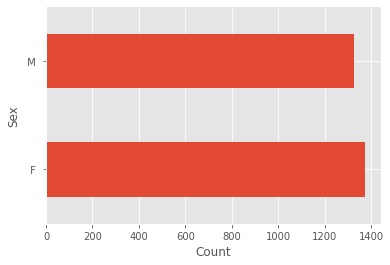

In [19]:
df['target'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Sex')

# Data Preprocessing


## Encoding

Since our task is the solving gender classification problem, our model's target value will be the sex which is indicated as column of `sex` in dataframe. `sex` column comprised of two different string values which are `F` for female, and `M` for male. Usually, in Deep Learning models we want to use numerical data only, therefore we should replace these string values with integers; `1` for male and `0` for female. This operation called 'encoding' in deep learning field and in order to implement encoding we are going to use `LabelEncoder()`function from `sklearn`'s `preprocessing` class.

In [20]:
from sklearn.preprocessing import LabelEncoder

# Encode sex category
# Male: 1, Female: 0
le = LabelEncoder()
df['target'] = le.fit_transform(df.target.values)
# Check a few records to make sure its processed successfully
df.head()

,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405
0,1,-43.703794,-42.898081,-42.031591,-41.125760,-42.074948,-42.946824,-42.900965,-43.390504,-44.539471,-47.025233,-47.015892,-45.466934,-44.388696,-44.803883,-43.969881,-43.063262,-43.416832,-43.676575,-43.811614,-44.149881,-45.211475,-45.735262,-43.433704,-25.558813,-13.446825,-7.694707,-5.727756,-4.150829,-5.003176,-13.396354,-26.283596,-13.699452,-3.092310,-4.838350,-12.953533,-16.378460,-18.166167,-14.267619,-16.384010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-43.083650,-43.054972,-41.703746,-39.983281,-40.930586,-41.673946,-41.469308,-38.498561,-37.184924,-37.958712,-38.025706,-36.346120,-37.010349,-38.911275,-39.232218,-39.347711,-40.226612,-42.311854,-43.403161,-43.757955,-43.163141,-41.313344,-36.479219,-21.684689,-13.956244,-11.571244,-11.808287,-8.430800,-5.633092,-7.078888,-7.554438,-9.628796,-12.837438,-15.407600,-15.290566,-11.151376,-6.142866,-3.169525,-3.982129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-40.070781,-40.995479,-40.485065,-39.162077,-39.753702,-40.130687,-39.897149,-39.106843,-39.228235,-38.768951,-35.955013,-33.561240,-33.211823,-32.332587,-31.671162,-33.570814,-32.783871,-32.288257,-33.997687,-37.510785,-41.305039,-44.634924,-44.970598,-41.434425,-35.127177,-28.549271,-15.049801,-6.313277,-5.872551,-11.116644,-14.988266,-5.809793,-3.335956,-1.665249,-2.928224,-7.885869,-12.815127,-17.857927,-18.578733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-41.581865,-41.047887,-41.748139,-42.433141,-40.802057,-39.691483,-38.136871,-36.647801,-35.164937,-35.907935,-35.175742,-36.497732,-36.099326,-35.917744,-37.899607,-38.851897,-38.379228,-38.148306,-38.589483,-39.337808,-42.102271,-44.002456,-43.457499,-42.724805,-36.567585,-30.435951,-13.871006,-4.556017,-1.293470,-1.403590,-0.421739,-0.944870,-2.311831,-2.474579,-2.373840,-2.994210,-6.593089,-9.383354,-10.072111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-43.617844,-41.956512,-39.753668,-37.786436,-34.413101,-34.980425,-35.760382,-37.362417,-37.818529,-36.306072,-36.069241,-38.607427,-42.365287,-42.538616,-43.690545,-44.764131,-44.727287,-43.571889,-43.050505,-42.461271,-42.703087,-44.402404,-42.920220,-26.688978,-14.837824,-8.907643,-6.233155,-3.679333,-2.762107,-3.015374,-3.967848,-2.880719,-2.502953,-3.174567,-3.435181,-6.048855,-9.540303,-6.843428,-4.441477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting Data into Training and Test Sets

While building real world machine learning models, it is quite common to split the dataset into 2 parts:

*   Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
*   Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.




In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1),  # Features
                                                    df.target,    # Targets
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=42
                                                    )

## Feature Scaling

Many models use some form of distance to inform them i.e. k-NN uses distance explicitly when making predictions. Since features on larger scales can unduly inﬂuence the model, we want features to be on a similar scale therefore we are applying scaling function to our data.

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.fit_transform(X_test.values)
# Lets see how the data present itself after normalisation 
X_train[0:10]

array([[0.55186318, 0.55890274, 0.60097028, ..., 1.        , 1.        ,
        1.        ],
       [0.72404102, 0.72908023, 0.69077743, ..., 1.        , 1.        ,
        1.        ],
       [0.46362382, 0.49366685, 0.49790877, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.6345915 , 0.68585783, 0.70890827, ..., 1.        , 1.        ,
        1.        ],
       [0.5204192 , 0.56035652, 0.60034243, ..., 1.        , 1.        ,
        1.        ],
       [0.37272885, 0.39847425, 0.4124939 , ..., 1.        , 1.        ,
        1.        ]])

# Machine Learning Classifiers

## KNN Model

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

steps = [('scaler', StandardScaler()), 
         ('knn', KNeighborsClassifier())]

pipe_knn  = Pipeline(steps)

param_range = [3, 5, 7, 9, 11, 13]
param_grid = {'knn__n_neighbors': param_range,
              'knn__weights': ['uniform', 'distance'],
              'knn__metric': ['euclidean', 'manhattan']}

cv_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
)

cv_knn.fit(X_train, y_train) 
knn_score = cv_knn.score(X_test, y_test)
y_pred = cv_knn.predict(X_test)

print("Best parameters for KNN: ", cv_knn.best_params_)
print("\nBest score: ", cv_knn.best_score_)
print("\nTest accuracy: %.4f" % knn_score )
print("\nConfusion matrix: ", confusion_matrix(y_test, y_pred))
print("\nClassification report: ", classification_report(y_test, y_pred))

Best parameters for KNN:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}

Best score:  0.7173835125448029

Test accuracy: 0.7412

Confusion matrix:  [[259  30]
 [110 142]]

Classification report:                precision    recall  f1-score   support

           0       0.70      0.90      0.79       289
           1       0.83      0.56      0.67       252

    accuracy                           0.74       541
   macro avg       0.76      0.73      0.73       541
weighted avg       0.76      0.74      0.73       541



## SVM Model

In [24]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

steps = [('scaler', StandardScaler()), 
         #('pca', PCA(n_components=10)),
         ('svc', SVC(random_state=42))]

pipe_svc  = Pipeline(steps)

param_range = [0.1, 1.0, 10.0,]
param_grid = {'svc__C': param_range,
              'svc__gamma': param_range}

cv_svc = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
)

cv_svc.fit(X_train, y_train)
svc_score = cv_svc.score(X_test, y_test)
y_pred = cv_svc.predict(X_test)

print("Best parameters for SVC: ", cv_svc.best_params_)
print("\nBest score: ", cv_svc.best_score_)
print("\nTest Accuracy: %.4f" % svc_score)
print("\nConfusion matrix: ", confusion_matrix(y_test, y_pred))
print("\nClassification report: ", classification_report(y_test, y_pred))

Best parameters for SVC:  {'svc__C': 10.0, 'svc__gamma': 0.1}

Best score:  0.588406680352408

Test Accuracy: 0.4658

Confusion matrix:  [[  0 289]
 [  0 252]]

Classification report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       289
           1       0.47      1.00      0.64       252

    accuracy                           0.47       541
   macro avg       0.23      0.50      0.32       541
weighted avg       0.22      0.47      0.30       541



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Deep Learning Classifiers

## Logistic Regression Model

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

In [26]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(2162, 1406, 1)

In [27]:
lr_model = Sequential()
lr_model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2', input_shape=(X_train.shape[1], 1)))
lr_model.add(Dropout(0.2))

lr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1406, 1)           2         
_________________________________________________________________
dropout (Dropout)            (None, 1406, 1)           0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [28]:
lr_model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.SGD(lr=0.000001), 
    metrics=['accuracy']
)

lr_history = lr_model.fit(
    X_train, 
    y_train, 
    batch_size=128, 
    epochs=10, 
    shuffle=True,
)

Epoch 1/10
17/17 [==============================] - 0s 4ms/step - loss: 2.4705 - accuracy: 0.4992
Epoch 2/10
17/17 [==============================] - 0s 2ms/step - loss: 2.4702 - accuracy: 0.4992
Epoch 3/10
17/17 [==============================] - 0s 2ms/step - loss: 2.4757 - accuracy: 0.4985
Epoch 4/10
17/17 [==============================] - 0s 2ms/step - loss: 2.4699 - accuracy: 0.4988
Epoch 5/10
17/17 [==============================] - 0s 2ms/step - loss: 2.4716 - accuracy: 0.4989
Epoch 6/10
17/17 [==============================] - 0s 3ms/step - loss: 2.4737 - accuracy: 0.4987
Epoch 7/10
17/17 [==============================] - 0s 3ms/step - loss: 2.4739 - accuracy: 0.4989
Epoch 8/10
17/17 [==============================] - 0s 3ms/step - loss: 2.4746 - accuracy: 0.4989
Epoch 9/10
17/17 [==============================] - 0s 2ms/step - loss: 2.4727 - accuracy: 0.4989
Epoch 10/10
17/17 [==============================] - 0s 2ms/step - loss: 2.4743 - accuracy: 0.4988


In [29]:
lr_score = lr_model.evaluate(x=X_test, y=y_test)[1]

17/17 [==============================] - 0s 2ms/step - loss: 0.8099 - accuracy: 0.4732


## ANN

In [30]:
# ANN architecture
ann_model = Sequential()
# First Dense layer
ann_model.add(Dense(64, input_shape=(X_train.shape[1], 1)))
ann_model.add(Activation('relu'))
# Second Dense layer
ann_model.add(Dense(128))
ann_model.add(Activation('relu'))
# Third Dense layer
ann_model.add(Dense(256))
ann_model.add(Activation('relu'))
# Fourth Dense layer
ann_model.add(Dense(128))
ann_model.add(Activation('relu'))
# Fifth Dense layer
ann_model.add(Dense(64))
ann_model.add(Activation('relu'))
ann_model.add(Dropout(0.3))
# Output Dense layer
ann_model.add(Dense(1))
ann_model.add(Activation('sigmoid'))

ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1406, 64)          128       
_________________________________________________________________
activation (Activation)      (None, 1406, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 1406, 128)         8320      
_________________________________________________________________
activation_1 (Activation)    (None, 1406, 128)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 1406, 256)         33024     
_________________________________________________________________
activation_2 (Activation)    (None, 1406, 256)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 1406, 128)        

In [31]:
ann_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

ann_history = ann_model.fit(
    X_train,
    y_train, 
    batch_size=64, 
    epochs=10,
    shuffle=True,
)

Epoch 1/10
34/34 [==============================] - 1s 21ms/step - loss: 0.6942 - accuracy: 0.4835
Epoch 2/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6933 - accuracy: 0.5015
Epoch 3/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6936 - accuracy: 0.4990
Epoch 4/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6935 - accuracy: 0.4908
Epoch 5/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6934 - accuracy: 0.4893
Epoch 6/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6932 - accuracy: 0.4990
Epoch 7/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6929 - accuracy: 0.5018
Epoch 8/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6927 - accuracy: 0.4983
Epoch 9/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6921 - accuracy: 0.5037
Epoch 10/10
34/34 [==============================] - 1s 20ms/step - loss: 0.6920 - accuracy: 0.5123


In [32]:
ann_score = ann_model.evaluate(x=X_test, y=y_test)[1]

17/17 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4885


## LSTM Based RNN Model

In [33]:
from keras.layers import Bidirectional, Embedding, LSTM, GRU

# The LSTM architecture
lstm_model = Sequential()
lstm_model.add(BatchNormalization(momentum=0.98, input_shape=(X_train.shape[1], 1)))
# First LSTM layer
lstm_model.add(Bidirectional(LSTM(128, return_sequences = True)))
lstm_model.add(Dropout(0.2))
# Output Dense layer
lstm_model.add(Flatten())
lstm_model.add(Dense(1, kernel_regularizer='l2'))
lstm_model.add(Activation('sigmoid'))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 1406, 1)           4         
_________________________________________________________________
bidirectional (Bidirectional (None, 1406, 256)         133120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1406, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 359936)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 359937    
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 493,061
Trainable params: 493,059
Non-trainable params: 2
________________________________________________

In [34]:
lstm_model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=0.0001), 
    metrics=['accuracy']
)

lstm_history = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=25, 
)

Epoch 1/25
17/17 [==============================] - 3s 188ms/step - loss: 0.6910 - accuracy: 0.5772
Epoch 2/25
17/17 [==============================] - 3s 184ms/step - loss: 0.6230 - accuracy: 0.7072
Epoch 3/25
17/17 [==============================] - 3s 184ms/step - loss: 0.5694 - accuracy: 0.7465
Epoch 4/25
17/17 [==============================] - 3s 185ms/step - loss: 0.5360 - accuracy: 0.7451
Epoch 5/25
17/17 [==============================] - 3s 185ms/step - loss: 0.5076 - accuracy: 0.7562
Epoch 6/25
17/17 [==============================] - 3s 184ms/step - loss: 0.5061 - accuracy: 0.7623
Epoch 7/25
17/17 [==============================] - 3s 184ms/step - loss: 0.5217 - accuracy: 0.7553
Epoch 8/25
17/17 [==============================] - 3s 185ms/step - loss: 0.4783 - accuracy: 0.7734
Epoch 9/25
17/17 [==============================] - 3s 184ms/step - loss: 0.4636 - accuracy: 0.7789
Epoch 10/25
17/17 [==============================] - 3s 185ms/step - loss: 0.4606 - accuracy: 0.7895

In [35]:
lstm_score = lstm_model.evaluate(x=X_test, y=y_test)[1]

17/17 [==============================] - 1s 42ms/step - loss: 1.7411 - accuracy: 0.5009


## CNN Model

In [36]:
cnn_model = Sequential()
# First Conv layer
cnn_model.add(Conv1D(256, 5, padding='same', input_shape=(X_train.shape[1], 1))) 
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling1D())
# Second Conv layer
cnn_model.add(Conv1D(128, 5, padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling1D())
# Third Conv layer
cnn_model.add(Conv1D(64, 5, padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling1D())
# Fourth Conv layer
cnn_model.add(Conv1D(64, 5, padding='same', kernel_regularizer='l2'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(AveragePooling1D())
# Output Dense layer
cnn_model.add(Flatten())
cnn_model.add(Dense(1, kernel_regularizer='l2'))
cnn_model.add(Activation('sigmoid'))
cnn_model.add(Dropout(0.3))
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1406, 256)         1536      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1406, 256)         1024      
_________________________________________________________________
activation_7 (Activation)    (None, 1406, 256)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1406, 256)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 703, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 703, 128)          163968    
_________________________________________________________________
batch_normalization_2 (Batch (None, 703, 128)         

In [37]:
cnn_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.0001),
    metrics=['accuracy'],
)

history = cnn_model.fit(
    X_train,
    y_train, 
    batch_size=128, 
    epochs=50, 
)

Epoch 1/50
17/17 [==============================] - 1s 57ms/step - loss: 3.6047 - accuracy: 0.5185
Epoch 2/50
17/17 [==============================] - 1s 52ms/step - loss: 3.3419 - accuracy: 0.6212
Epoch 3/50
17/17 [==============================] - 1s 52ms/step - loss: 3.3652 - accuracy: 0.6573
Epoch 4/50
17/17 [==============================] - 1s 51ms/step - loss: 3.5810 - accuracy: 0.6549
Epoch 5/50
17/17 [==============================] - 1s 52ms/step - loss: 3.3052 - accuracy: 0.6873
Epoch 6/50
17/17 [==============================] - 1s 52ms/step - loss: 3.2266 - accuracy: 0.7109
Epoch 7/50
17/17 [==============================] - 1s 52ms/step - loss: 3.2424 - accuracy: 0.6864
Epoch 8/50
17/17 [==============================] - 1s 52ms/step - loss: 3.3227 - accuracy: 0.7007
Epoch 9/50
17/17 [==============================] - 1s 52ms/step - loss: 3.2347 - accuracy: 0.7118
Epoch 10/50
17/17 [==============================] - 1s 52ms/step - loss: 3.3678 - accuracy: 0.7007
Epoch 11/

In [38]:
cnn_score = cnn_model.evaluate(x=X_test, y=y_test)[1]

17/17 [==============================] - 0s 8ms/step - loss: 0.8823 - accuracy: 0.7652


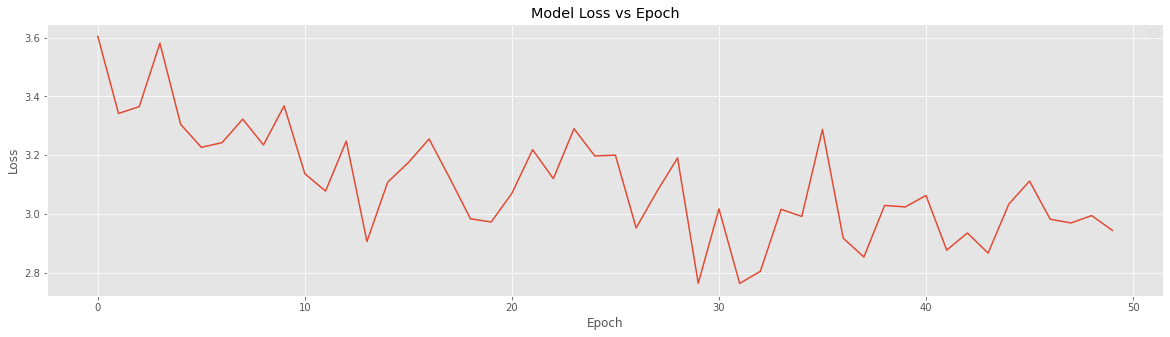

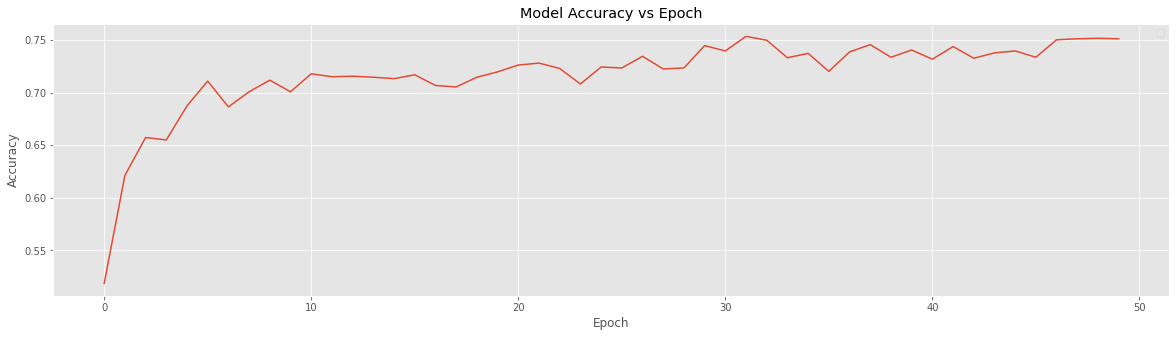

In [39]:
# Plot Loss vs Epoch
plt.figure(figsize=(20, 5))  # Create a figure and set figure size
plt.title('Model Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.plot(history.history['loss'])
plt.show()

# Plot Accuracy vs Epoch
plt.figure(figsize=(20, 5))  # Create a figure and set figure size
plt.title('Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.plot(history.history['accuracy'])
plt.show()

In [40]:
# Save model, weights and state of the optimizer
model_name = 'gender_classification_cnn.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
cnn_model.save(model_path)
print("Save model and weights at %s " % model_path)

Save model and weights at /content/saved_models/gender_classification_cnn.h5 


In [43]:
best_model = load_model('saved_models/gender_classification_cnn.h5')
print("Loaded model from disk.")

Loaded model from disk.


# Comparasion

In [49]:
print("KNN model's accuracy: %.2f%%" % knn_score)
print("SVM model's accuracy: %.2f%%" % svc_score)
print("Logistic Regression model's accuracy: %.2f%%}" % (lr_score*100))
print("ANN model's accuracy: %.2f%%" % (ann_score*100))
print("LSTM based RNN model's accuracy: %.2f%%" % (lstm_score*100))
print("CNN model's accuracy: %.2f%%" % (cnn_score*100))

KNN model's accuracy: 0.74%
SVM model's accuracy: 0.47%
Logistic Regression model's accuracy: 47.32%}
ANN model's accuracy: 48.85%
LSTM based RNN model's accuracy: 50.09%
CNN model's accuracy: 76.52%


Obviously, CNN model outperforms the other models.